Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing Skin Cancer Data
#### To do: Take necessary actions to read the data

### Importing all the important libraries

In [ ]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from glob import glob
from tensorflow.keras.layers import BatchNormalization, Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.layers.experimental.preprocessing import Rescaling
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau
from keras.utils import to_categorical # convert to one-hot-encoding

In [ ]:
## If you are using the data by mounting the google drive, use the following :

##Ref:https://towardsdatascience.com/downloading-datasets-into-google-drive-via-google-colab-bcb1b30b0166

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [ ]:
# Defining the path for train and test images
## Todo: Update the paths of the train and test dataset
data_dir_train = pathlib.Path("/content/drive/MyDrive/Colab Notebooks/Skin cancer ISIC The International Skin Imaging Collaboration/Train")
data_dir_test = pathlib.Path('/content/drive/MyDrive/Colab Notebooks/Skin cancer ISIC The International Skin Imaging Collaboration/Test')

In [ ]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2308
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [ ]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [ ]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset



train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    batch_size=batch_size,                 # Number of images to return in each batch
    image_size=(img_height, img_width),         # Resize images to this size
    shuffle=True,                  # Whether to shuffle the data
    seed=123,                      # Seed for shuffling
    validation_split=0.2,          # Fraction of data to reserve for validation
    subset='training'              # Use 'training' or 'validation' for the respective subset
)

Found 6808 files belonging to 9 classes.
Using 5447 files for training.


In [ ]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset


val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    batch_size=batch_size,
    image_size=(img_height, img_width),
    shuffle=True,
    seed=123,
    validation_split=0.2,
    subset='validation'
)

Found 6808 files belonging to 9 classes.
Using 1361 files for validation.


In [ ]:
# List out all the classes of skin cancer and store them in a list.
# You can find the class names in the class_names attribute on these datasets.
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)



['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


In [ ]:
num_classes = len(train_ds.class_names)

def one_hot_encode(images, labels):
    labels = tf.one_hot(labels, num_classes)
    return images, labels

train_ds = train_ds.map(one_hot_encode)
val_ds = val_ds.map(one_hot_encode)

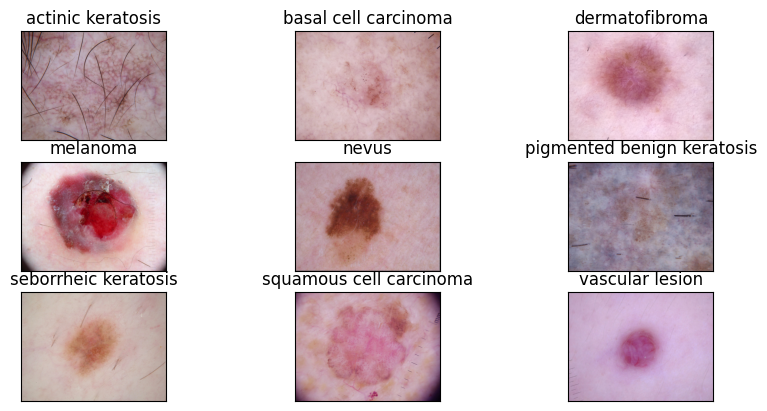

In [ ]:
from skimage import io  # Importing io from skimage
from skimage.transform import resize
from pathlib import Path

f, axes = plt.subplots(3, 3, sharey=True)
f.set_figwidth(10)


for ii in range(len(class_names)):
    re = class_names[ii]+'/*.jpg'
    sample_img_path = list(data_dir_train.glob(re))[0] #picking the first image in the folder
    img = io.imread(sample_img_path)
    img = resize(img,(450,600))
    kk = ii//3
    jj = ii%3
    axes[kk][jj].set_xticks([])
    axes[kk][jj].set_yticks([])
    axes[kk][jj].imshow(img)
    axes[kk][jj].set_title(class_names[ii])




### Visualize the data
#### Todo, create a code to visualize one instance of all the nine classes present in the dataset

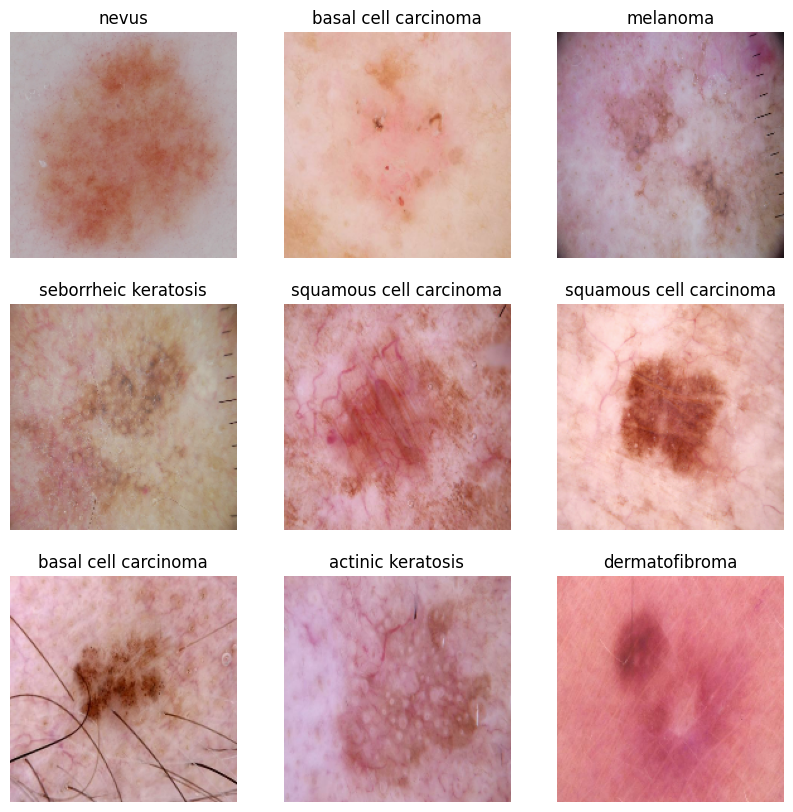

In [ ]:
import matplotlib.pyplot as plt

### your code goes here, you can use training or validation data to visualize


plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        class_index = tf.argmax(labels[i]).numpy()  # Convert one-hot encoding to class index
        plt.title(class_names[class_index])
        plt.axis("off")
plt.show()

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [ ]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model
#### Todo: Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [ ]:
### Your code goes here
preprocessing_layers = [
    tf.keras.layers.experimental.preprocessing.Rescaling(1./255, input_shape=(180, 180, 3))
]



input_shape = (180,180,3)
lr = 1e-5
init = 'normal'
activ = 'relu'

model = Sequential()
model.add(tf.keras.layers.experimental.preprocessing.Rescaling(1./255, input_shape=(180, 180, 3)))


model.add(Conv2D(32, kernel_size=(3, 3),
                 activation=activ,
                 input_shape=input_shape))

model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, kernel_size=(3, 3),
                 activation=activ))

model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, kernel_size=(3, 3), activation=activ))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())

model.add(Dense(512, activation=activ))
model.add(Activation(activ))
model.add(Dropout(0.5))
model.add(Dense(9))
model.add(Activation('softmax'))


model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 89, 89, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 87, 87, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 43, 43, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 41, 41, 128)       7

### Compile the model
Choose an appropirate optimiser and loss function for model training

In [ ]:
### Todo, choose an appropirate optimiser and loss function
model.compile(optimizer='adam',
              loss="categorical_crossentropy",
              metrics=['accuracy'])


In [ ]:
# View the summary of all layers
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 89, 89, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 87, 87, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 43, 43, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 41, 41, 128)       7

### Train the model

In [ ]:
epochs = 20
history = model.fit(
  train_ds,
    batch_size=32,
  validation_data=val_ds,
  epochs=epochs
)


Epoch 1/20
171/171 [==============================] - 1095s 2s/step - loss: 1.8682 - accuracy: 0.2919 - val_loss: 1.6046 - val_accuracy: 0.3850
Epoch 2/20
171/171 [==============================] - 7s 42ms/step - loss: 1.4993 - accuracy: 0.4294 - val_loss: 1.3908 - val_accuracy: 0.4607
Epoch 3/20
171/171 [==============================] - 7s 42ms/step - loss: 1.2953 - accuracy: 0.5179 - val_loss: 1.2443 - val_accuracy: 0.5459
Epoch 4/20
171/171 [==============================] - 7s 43ms/step - loss: 1.1731 - accuracy: 0.5790 - val_loss: 1.0920 - val_accuracy: 0.5915
Epoch 5/20
171/171 [==============================] - 7s 42ms/step - loss: 1.0367 - accuracy: 0.6231 - val_loss: 0.9216 - val_accuracy: 0.6576
Epoch 6/20
171/171 [==============================] - 7s 42ms/step - loss: 0.8902 - accuracy: 0.6774 - val_loss: 0.7943 - val_accuracy: 0.7112
Epoch 7/20
171/171 [==============================] - 7s 43ms/step - loss: 0.7249 - accuracy: 0.7448 - val_loss: 0.6813 - val_accuracy: 0.773

### Visualizing training results

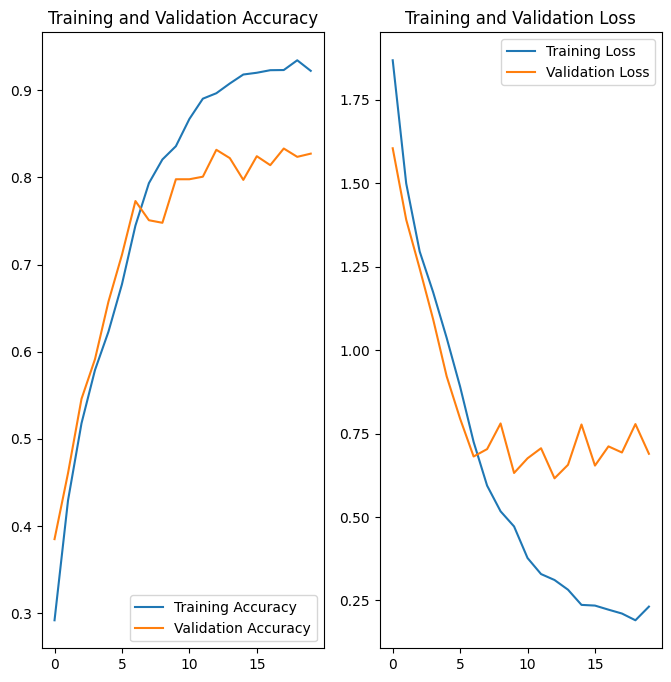

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit

### Write your findings here


### Observations:


*   From the above patterns, it is observed that Training Accuracy got improved to 81.66% and Training Loss got reduced to as low as 0.5064. These, metrics seems to be good.

*   However, Validation Accuracy and Validation Loss were obtained to be 54.69% and 2.2259 which are not so good.

*   Hence, we can observe the Overfitting with this model. Further, by using data augmentation techniques such as Image Rotation, Image flip, Image Zoom, etc., we can get better results.

In [ ]:
# Todo, after you have analysed the model fit history for presence of underfit or overfit, choose an appropriate data augumentation strategy.
# Your code goes here

data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal_and_vertical"),
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomZoom(0.2)
])

# Apply data augmentation to the training dataset
train_aug_ds = train_ds.map(lambda x, y: (data_augmentation(x, training=True), y))

In [ ]:
# Todo, visualize how your augmentation strategy works for one instance of training image.
# Your code goes here


### Todo:
### Create the model, compile and train the model


In [ ]:
## You can use Dropout layer if there is an evidence of overfitting in your findings

## Your code goes here

#preprocessing_layers = [
#    tf.keras.layers.experimental.preprocessing.Rescaling(1./255, input_shape=(180, 180, 3))
#]



input_shape = (180,180,3)
lr = 1e-5
init = 'normal'
activ = 'relu'

model = Sequential()
#model.add(tf.keras.layers.experimental.preprocessing.Rescaling(1./255, input_shape=(180, 180, 3)))


model.add(Conv2D(32, kernel_size=(3, 3),
                 activation=activ,
                 input_shape=input_shape))

model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, kernel_size=(3, 3),
                 activation=activ))

model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, kernel_size=(3, 3), activation=activ))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())

model.add(Dense(512, activation=activ))
model.add(Activation(activ))
model.add(Dropout(0.5))
model.add(Dense(9))
model.add(Activation('softmax'))

model.summary()


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 89, 89, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 87, 87, 64)        18496     
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 43, 43, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 41, 41, 128)       73856     
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 20, 20, 128)      

### Compiling the model

In [ ]:
## Your code goes here

model.compile(optimizer='adam',
              loss="categorical_crossentropy",
              metrics=['accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 89, 89, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 87, 87, 64)        18496     
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 43, 43, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 41, 41, 128)       73856     
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 20, 20, 128)      

### Training the model

In [ ]:
## Your code goes here, note: train your model for 20 epochs
# history = ## your training code

epochs = 20
history = model.fit(
  train_aug_ds,
    batch_size=32,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
171/171 [==============================] - 42s 237ms/step - loss: 13.6316 - accuracy: 0.1737 - val_loss: 2.1451 - val_accuracy: 0.1727
Epoch 2/20
171/171 [==============================] - 41s 239ms/step - loss: 2.1683 - accuracy: 0.1731 - val_loss: 2.1876 - val_accuracy: 0.1198
Epoch 3/20
171/171 [==============================] - 41s 241ms/step - loss: 2.1885 - accuracy: 0.1494 - val_loss: 2.1599 - val_accuracy: 0.1616
Epoch 4/20
171/171 [==============================] - 41s 238ms/step - loss: 2.5709 - accuracy: 0.1494 - val_loss: 2.1849 - val_accuracy: 0.1425
Epoch 5/20
171/171 [==============================] - 41s 240ms/step - loss: 2.1700 - accuracy: 0.1496 - val_loss: 2.1662 - val_accuracy: 0.1624
Epoch 6/20
171/171 [==============================] - 40s 233ms/step - loss: 2.1605 - accuracy: 0.1505 - val_loss: 2.1832 - val_accuracy: 0.1418
Epoch 7/20
171/171 [==============================] - 41s 237ms/step - loss: 2.1609 - accuracy: 0.1562 - val_loss: 2.1524 - val_a

### Visualizing the results

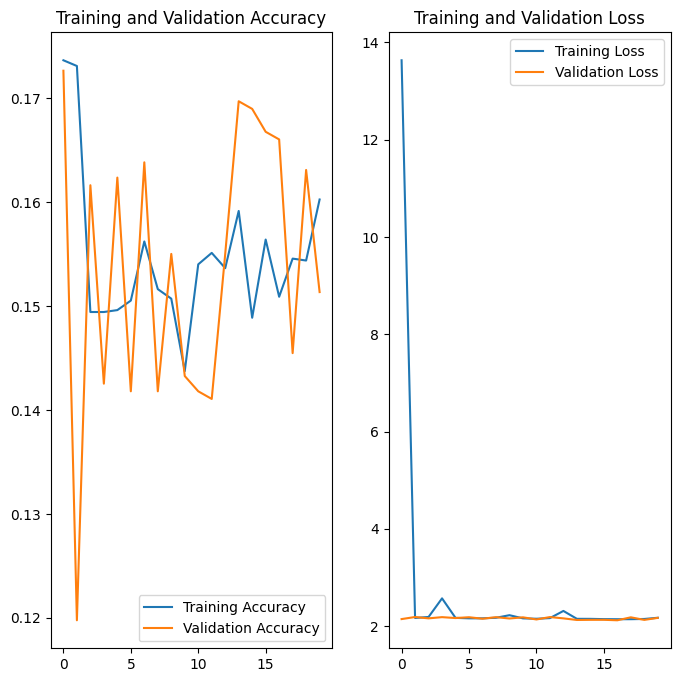

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit. Do you think there is some improvement now as compared to the previous model run?



### Observations:



*   From the above patterns, it is observed that Training Accuracy obtained as 55.07% and Training Loss obtained to be 1.27. These, metrics seems to be average.

*   Further, Validation Accuracy and Validation Loss were obtained to be 54.91% and 1.34.
*   Hence, we can accept that Overfitting problem is solved.


*   However, there is still more scope for improving the Accuracy of the model. This can be done by doing class Balancing and Data Normalization.

#### **Todo:** Find the distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

In [ ]:
## Your code goes here.

import matplotlib.pyplot as plt
data = dict()

for i in class_names:
  data[i] = []

plt.figure(figsize=(10, 10))
for images, labels in train_ds:
  for i in range(9):
    #data[class_names[labels[i]]].append(images[i].numpy().astype("uint8"))
    data[class_name].append(images[i].numpy().astype("uint8"))

for i in data:
  data[i] = len(data[i])

f = plt.figure()
f.set_figwidth(20)
f.set_figheight(20)

plt.bar(range(len(data)), list(data.values()), align='center')
plt.xticks(range(len(data)), list(data.keys()))
plt.show()




TypeError: only integer scalar arrays can be converted to a scalar index

<Figure size 1000x1000 with 0 Axes>

#### **Todo:** Write your findings here:
#### - Which class has the least number of samples?
#### - Which classes dominate the data in terms proportionate number of samples?


#### **Todo:** Rectify the class imbalance
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [ ]:
!pip install Augmentor

To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [ ]:
path_to_training_dataset="/content/drive/MyDrive/Colab Notebooks/Skin cancer ISIC The International Skin Imaging Collaboration/Train/"
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.




Initialised with 114 image(s) found.
Output directory set to /content/drive/MyDrive/Colab Notebooks/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7E8D812772E0>: 100%|██████████| 500/500 [00:19<00:00, 25.45 Samples/s]


Initialised with 402 image(s) found.
Output directory set to /content/drive/MyDrive/Colab Notebooks/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7E8D8152A770>: 100%|██████████| 500/500 [00:18<00:00, 27.32 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/drive/MyDrive/Colab Notebooks/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7E8D813D3C70>: 100%|██████████| 500/500 [00:18<00:00, 26.80 Samples/s]


Initialised with 445 image(s) found.
Output directory set to /content/drive/MyDrive/Colab Notebooks/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x768 at 0x7E8D8127EA40>: 100%|██████████| 500/500 [01:31<00:00,  5.47 Samples/s]


Initialised with 367 image(s) found.
Output directory set to /content/drive/MyDrive/Colab Notebooks/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=919x802 at 0x7E8D8641EFE0>: 100%|██████████| 500/500 [01:17<00:00,  6.45 Samples/s]


Initialised with 472 image(s) found.
Output directory set to /content/drive/MyDrive/Colab Notebooks/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7E8D813D2F80>: 100%|██████████| 500/500 [00:19<00:00, 26.26 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/drive/MyDrive/Colab Notebooks/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7E8D861B8C70>: 100%|██████████| 500/500 [00:38<00:00, 12.82 Samples/s]


Initialised with 191 image(s) found.
Output directory set to /content/drive/MyDrive/Colab Notebooks/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7E8D86430F70>: 100%|██████████| 500/500 [00:18<00:00, 27.10 Samples/s]


Initialised with 145 image(s) found.
Output directory set to /content/drive/MyDrive/Colab Notebooks/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7E8D813D2DA0>: 100%|██████████| 500/500 [00:20<00:00, 24.92 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [ ]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

9000


### Lets see the distribution of augmented data after adding new images to the original training data.

In [ ]:
path_list = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list

['/content/drive/MyDrive/Colab Notebooks/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0027759.jpg_dfa469d7-c455-4acf-8ba6-bc944a85a7ed.jpg',
 '/content/drive/MyDrive/Colab Notebooks/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0030712 (1).jpg_f42ea672-0189-4466-be9f-681239711a62.jpg',
 '/content/drive/MyDrive/Colab Notebooks/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0028419.jpg_4774a369-7f7a-4fab-8ae4-821dece9a643.jpg',
 '/content/drive/MyDrive/Colab Notebooks/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output/basal cell carcinoma_original_ISIC_0025530.jpg_74b792cf-eaa1-4ce3-ab06-c65de777e783.jpg',
 '/content/drive/MyDrive/Colab Notebooks/Skin cancer ISIC The International Skin Imaging

In [ ]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new

['basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',
 'basal cell carcinoma',


In [ ]:
#dataframe_dict_new = dict(zip(path_list_new, lesion_list_new))

dataframe_dict_new = dict(zip(path_list, lesion_list_new))

In [ ]:
#df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
#new_df = original_df.append(df2)

df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
new_df = df2

In [ ]:
new_df['Label'].value_counts()

Label
basal cell carcinoma          1000
squamous cell carcinoma       1000
seborrheic keratosis          1000
dermatofibroma                1000
vascular lesion               1000
pigmented benign keratosis    1000
melanoma                      1000
nevus                         1000
actinic keratosis             1000
Name: count, dtype: int64

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### **Todo**: Train the model on the data created using Augmentor

In [ ]:
batch_size = 32
img_height = 180
img_width = 180

#### **Todo:** Create a training dataset

In [ ]:
data_dir_train="/content/drive/MyDrive/Colab Notebooks/Skin cancer ISIC The International Skin Imaging Collaboration/Train"
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'training',
  image_size=(img_height, img_width),
  batch_size=batch_size)


Found 11308 files belonging to 9 classes.
Using 9047 files for training.


#### **Todo:** Create a validation dataset

In [ ]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'validation',
  image_size=(img_height, img_width),
  batch_size=batch_size)


Found 11308 files belonging to 9 classes.
Using 2261 files for validation.


num_classes = len(train_ds.class_names)

def one_hot_encode(images, labels):
    labels = tf.one_hot(labels, num_classes)
    return images, labels

train_ds = train_ds.map(one_hot_encode)
val_ds = val_ds.map(one_hot_encode)

In [ ]:
num_classes = len(train_ds.class_names)

def one_hot_encode(images, labels):
    labels = tf.one_hot(labels, num_classes)
    return images, labels

train_ds = train_ds.map(one_hot_encode)
val_ds = val_ds.map(one_hot_encode)

#### **Todo:** Create your model (make sure to include normalization)

In [ ]:
## your code goes here

model = Sequential()



model.add(Conv2D(32, kernel_size=(3, 3),
                 activation=activ,
                 input_shape=input_shape))

model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, kernel_size=(3, 3),
                 activation=activ))

model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, kernel_size=(3, 3), activation=activ))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())

model.add(Dense(512, activation=activ))
model.add(Activation(activ))
model.add(Dropout(0.5))
#model.add(Dense(9))
#model.add(Activation('softmax'))
model.add(Dense(9, activation='softmax'))

#### **Todo:** Compile your model (Choose optimizer and loss function appropriately)

In [ ]:
## your code goes here

model.compile(optimizer='adam',
              loss="categorical_crossentropy",
              metrics=['accuracy'])
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 89, 89, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (None, 87, 87, 64)        18496     
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 43, 43, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_8 (Conv2D)           (None, 41, 41, 128)       73856     
                                                                 
 max_pooling2d_8 (MaxPoolin  (None, 20, 20, 128)      

#### **Todo:**  Train your model

In [ ]:
epochs = 30
history = model.fit(
  train_ds,
    batch_size=32,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
283/283 [==============================] - 70s 233ms/step - loss: 10.1003 - accuracy: 0.1455 - val_loss: 2.1886 - val_accuracy: 0.1327
Epoch 2/20
283/283 [==============================] - 74s 257ms/step - loss: 2.1571 - accuracy: 0.1507 - val_loss: 2.1263 - val_accuracy: 0.1592
Epoch 3/20
283/283 [==============================] - 74s 258ms/step - loss: 2.1765 - accuracy: 0.1481 - val_loss: 2.1882 - val_accuracy: 0.1331
Epoch 4/20
283/283 [==============================] - 74s 258ms/step - loss: 2.3629 - accuracy: 0.1298 - val_loss: 2.1537 - val_accuracy: 0.1468
Epoch 5/20
283/283 [==============================] - 67s 232ms/step - loss: 2.1621 - accuracy: 0.1374 - val_loss: 2.1428 - val_accuracy: 0.1597
Epoch 6/20
283/283 [==============================] - 74s 256ms/step - loss: 2.4387 - accuracy: 0.1412 - val_loss: 2.1619 - val_accuracy: 0.1477
Epoch 7/20
283/283 [==============================] - 67s 232ms/step - loss: 2.1620 - accuracy: 0.1465 - val_loss: 2.1481 - val_a

#### **Todo:**  Visualize the model results

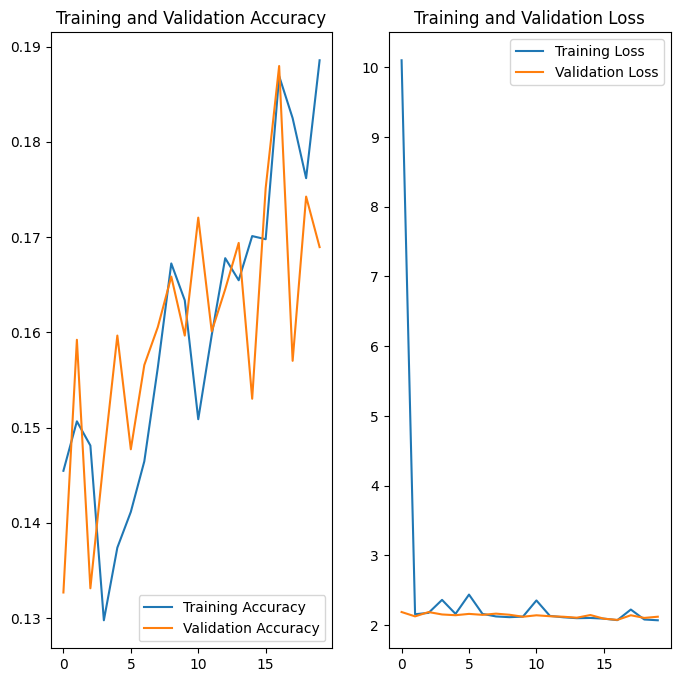

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### **Todo:**  Analyze your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?



# Final Observations:
Overfitting was observed with Initial Model. This means the training accuracy was high, but the validation accuracy was significantly lower, indicating Overfitting. This might have happened due to non-usage of Data Generator provisions such as Class Balancing, Data Augmentation, etc.

 After the execution of Class Imbalancing rectification using Data Augmentation and Batch Normalization, it is observed that both Training Accuracy & Validation Accuracy got improved. Hence, we can say that Overfitting is improved.

 Also, we can observe that, patterns for Accuracy and Loss for both Training and Validation data sets got converged with each other from the graphs generated above.


## Reasons for Improved Performance:

### Class Balancing:
class balancing technique enhanced the performance and reliability of machine learning models by ensuring better accuracy by reducing bias leading to learn more effectively from each & every class with reduced bias towards majority classes.

### Batch Normalization:
It is observed that Batch Normalization enhanced the training of deep neural networks by improving training stability, reducing overfitting, accelerating convergence, and simplifying the optimization process. These benefits have contributed to convergence of patterns corresponding to Accuracy and Loss for both Training and Validation data sets.


### Dropout:
Droupout layers were introduced inorder to randomly drop few units thereby preventing Overfitting.

### ImageDataGenerator:
Further, it is believed that features such as rotation, flipping, etc., of ImageDataGenerator contributed for better test accuracy as well as validation accuracy and lessened overfitting.

